In [14]:
from const import *
from function import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
import itertools

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from tqdm import tqdm
from catboost import CatBoostRegressor
from catboost import Pool

warnings.simplefilter('ignore')

In [15]:
data_path = '../1.data/'
train_file_name = 'train.csv'
test_file_name  = 'test.csv'

In [16]:
def creansing_dataset(df):
    # year
    is_error_year = df['year'] > 2023
    df.loc[is_error_year, 'year'] = df[is_error_year]['year'] - 1000
    # size
    df['size'] = df['size'].replace(size_replace)
    # manufacturer
    df['manufacturer'] = df['manufacturer'].replace(manufactuer_replace)

    return df

In [17]:
train_df = pd.read_csv(f'{data_path}{train_file_name}')
test_df = pd.read_csv(f'{data_path}{test_file_name}')
master_df = pd.concat([train_df, test_df])

In [18]:
non_cols = ['id', 'price']
num_cols = ['year', 'odometer']
cat_cols = [col for col in train_df.columns if col not in non_cols + num_cols]

In [19]:
def creansing_dataset(df):
    # year
    is_error_year = df['year'] > 2023
    df.loc[is_error_year, 'year'] = df[is_error_year]['year'] - 1000
    # size
    df['size'] = df['size'].replace(size_replace)
    # manufacturer
    df['manufacturer'] = df['manufacturer'].replace(manufactuer_replace)

    return df


def create_num_features(df):
    df['elapsed_year'] = 2023 - df['year']
    del df['year']

    return df


def create_cat_features(df):
    for col in cat_cols:
        df[col] = df[col].factorize()[0]
        df[col] = df[col].astype('category')
    return df


def create_features_main(df):
    df = creansing_dataset(df)
    df = create_num_features(df)
    df = create_cat_features(df)

    return df

In [20]:
def built_catboost_model(cat_features, Xt, yt, Xe, ye):
    model = \
        CatBoostRegressor(
            learning_rate = 0.1,
            iterations=300,
            loss_function = 'MAPE',
            early_stopping_rounds = 30,
            random_seed = 42
        )

    model.fit(
        X = Xt, y = yt,
        eval_set = (Xe, ye),
        cat_features = cat_features, 
        use_best_model = True, 
        verbose = 500
    )

    return model


def mape(true, pred):
    return np.mean(np.abs((pred - true) / true)) 

In [21]:
def plot_result(preds):
    pred_df_l = []
    for i in range(cv):
        pred_df_l.append(
            pd.DataFrame(np.array(preds[i]).T, columns=['id', 'actual', 'pred'])
        )

    pred_df = pd.concat(pred_df_l)

    plt.figure(figsize=(8,5), facecolor="azure", edgecolor="coral", linewidth=2)
    bins = np.linspace(0, pred_df['actual'].max(), 200)
    plt.hist(pred_df['actual'], bins, alpha = 0.5, label='actual')
    plt.hist(pred_df['pred'], bins, alpha = 0.5, label='b')


    fig = plt.figure(figsize=(5,5), facecolor="azure", edgecolor="coral", linewidth=2)
    ax1 = fig.add_subplot()
    ax1.set_ylim([0, pred_df['actual'].max()])
    ax1.set_xlim([0, pred_df['actual'].max()])
    ax1.scatter(pred_df['actual'], pred_df['pred'])


def plot_importance(importnace_l):
    imp_df = pd.DataFrame(index=input_cols)
    for i in range(len(importnace_l)):
        imp_df[f'cv{i+1}'] = importnace_l[i]

    imp_df['mean'] = imp_df.mean(axis=1)
    imp_df = imp_df.sort_values('mean')

    plt.figure(figsize=(8,12), facecolor="azure", edgecolor="coral", linewidth=2)
    plt.boxplot(
        [imp_df.T[col].values for col in imp_df.index],
        labels = imp_df.index, 
        vert=False
    )

In [22]:
master_df = create_features_main(master_df)
train_df = master_df[~master_df['price'].isnull()].reset_index(drop=True).copy()
train_df['price'] = np.log(train_df['price'])
test_df  = master_df[master_df['price'].isnull()].copy()

In [23]:
cv = 4
kf = KFold(n_splits=cv)

models = []
preds  = []
scores = []
importnace_l = []

input_cols = train_df.drop(columns=['price', 'id']).columns

In [24]:
for train_index, valid_index in kf.split(train_df):
    x_train = train_df.iloc[train_index].drop(columns=['price', 'id'])
    y_train = train_df.iloc[train_index]['price']
    x_valid = train_df.iloc[valid_index].drop(columns=['price', 'id'])
    y_valid = train_df.iloc[valid_index]['price']

    model = built_catboost_model(
        cat_cols, x_train, y_train, x_valid, y_valid
    )

    valid_pred = model.predict(x_valid)

    scores.append(mape(y_valid, valid_pred).round(5))
    preds.append([valid_index, y_valid.values, valid_pred])
    models.append(model)
    importnace_l.append(model.get_feature_importance())

    del x_train, y_train, x_valid, y_valid, model

0:	learn: 0.0696080	test: 0.0698441	best: 0.0698441 (0)	total: 153ms	remaining: 45.8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.05162327659
bestIteration = 230

Shrink model to first 231 iterations.
0:	learn: 0.0697357	test: 0.0695794	best: 0.0695794 (0)	total: 161ms	remaining: 48.1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.05096798037
bestIteration = 254

Shrink model to first 255 iterations.
0:	learn: 0.0696381	test: 0.0697579	best: 0.0697579 (0)	total: 218ms	remaining: 1m 5s
299:	learn: 0.0480646	test: 0.0509100	best: 0.0509100 (299)	total: 48.3s	remaining: 0us

bestTest = 0.05090996753
bestIteration = 299

0:	learn: 0.0697183	test: 0.0695811	best: 0.0695811 (0)	total: 179ms	remaining: 53.5s
299:	learn: 0.0483373	test: 0.0501223	best: 0.0501223 (299)	total: 43.1s	remaining: 0us

bestTest = 0.05012233241
bestIteration = 299



In [25]:
print(f'scores = {scores}')
print(f'mean_score = {np.mean(scores).round(5)}')

scores = [0.05162, 0.05097, 0.05091, 0.05012]
mean_score = 0.0509


In [30]:
a = 10
a_ = np.log(10)

print(a, a_, np.exp(a_))

10 2.302585092994046 10.000000000000002


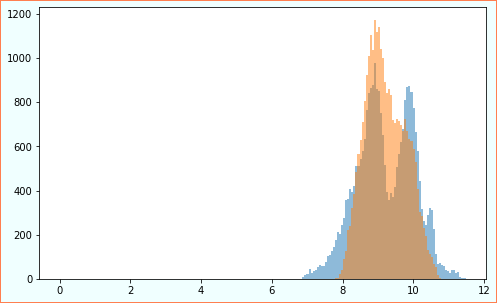

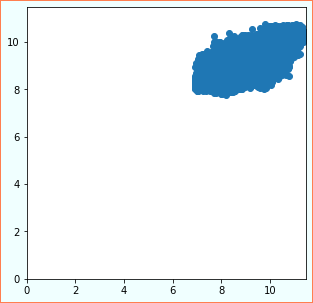

In [26]:
plot_result(preds)

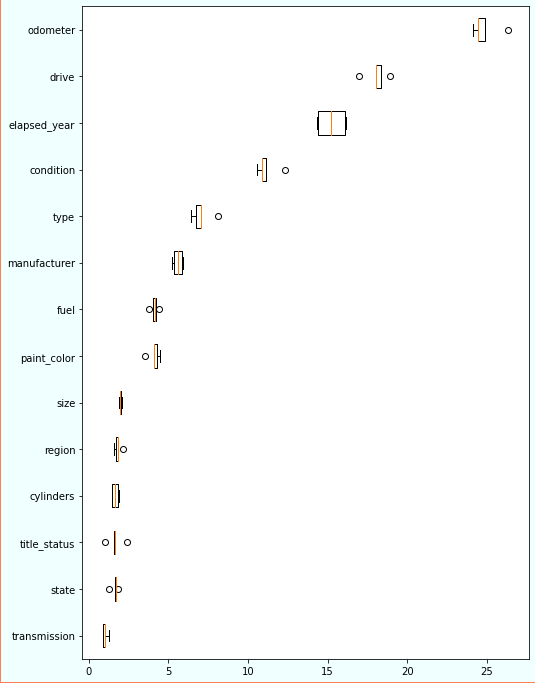

In [27]:
plot_importance(importnace_l)